In [4]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time
from IPython.display import Image

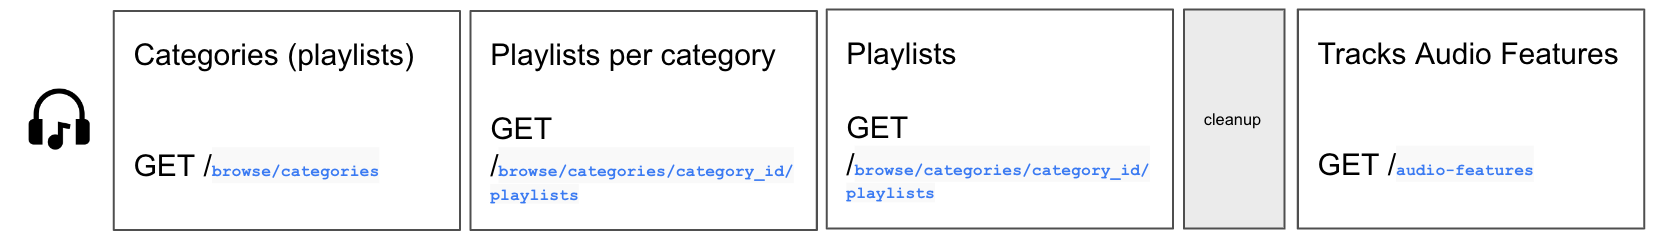

In [5]:
Image(filename='song-collecting-process.png')

In [ ]:
SPOTIPY_CLIENT_ID=''
SPOTIPY_CLIENT_SECRET=''

In [ ]:
auth_manager = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

### Get all available categories for playlists

In [ ]:
def get_categories():
    res = sp.categories(limit=50)
    categories = res['categories']['items']
    df = pd.DataFrame([], columns=['id', 'name'])
    cats = []
    for c in categories:
        if c['id'] not in ['0JQ5DAqbMKFF1br7dZcRtK', 'funk', 'word']:
            cats.append({c['id'] : c['name']})

    return cats

categories = get_categories()

### Get playlists for collected categories

In [ ]:
def get_playlists_by_category(category_id, offset=0):
    res = sp.category_playlists(category_id=category_id, country=None, limit=50, offset=offset)
    pl = res['playlists']['items']
    return pl


def create_playlists_collection(cat_list):
    df = pd.DataFrame([], columns=['category_id', 'category_name', 'playlist_id', 'name', 
                                   'description', 'owner_display_name', 'owner_id', 'total_tracks'])
    for c in cat_list:
        cat = list(c.items())[0]
        for i in range(0, 150, 50):
            pls = get_playlists_by_category(cat[0], i)
            time.sleep(3)
            for pl in pls: 
                try:                      
                    df.at[df.shape[0]] = [cat[0], cat[1], pl['id'], pl['name'], pl['description'], 
                                          pl['owner']['display_name'], pl['owner']['id'], pl['tracks']['total']]  
                except:
                    pass
    return df
        
playlists_collection = create_playlists_collection(categories)

In [ ]:
playlists_collection.to_csv('playlists-collections.csv', index=False);

### Get tracks from collected playlists

In [ ]:
tracks = pd.DataFrame([], columns=['playlist_id', 'track_id', 'name', 'artists', 'popularity', 'duration_ms'])

In [ ]:
def get_playlist(playlist_id):
    return sp.playlist(playlist_id)

def get_artists_name(artists_list):
    return ', '.join([artist['name'] for artist in artists_list])
    
def create_tracks_collection(df, playlists):
    for pl_id in playlists:
        pl = get_playlist(pl_id)
        for item in pl['tracks']['items']:
            try:
                df.at[df.shape[0]] = [pl_id, item['track']['id'],item['track']['name'], 
                                      get_artists_name(item['track']['artists']),
                                      item['track']['popularity'],item['track']['duration_ms']]
            except:
                pass
        time.sleep(2)

In [ ]:
create_tracks_collection(tracks, playlists_collection['playlist_id'][1000:1500])

In [ ]:
tracks.to_csv('tracks.csv', index=False) # collected index 0 - 1500

### Clean tracks from double entries

In [ ]:
def clean_tracks_list(tracks):
    t = tracks.copy()
    for track in t['track_id'].unique():
        subset = t.query('track_id == @track')
        if len(subset.index) > 1:
            t.drop(index=subset.index[1:], inplace=True)
    return t

tracks_clean = clean_tracks_list(tracks)

### Get audio features for all tracks

In [ ]:
def get_audio_features(tracks):
    t = tracks.copy()
    t['danceability'] = 0
    t['energy'] = 0
    t['loudness'] = 0
    t['speechiness'] = 0
    t['acousticness'] = 0
    t['instrumentalness'] = 0
    t['liveness'] = 0
    t['valence'] = 0
    t['tempo'] = 0
    t['key'] = 0
    t['mode'] = 0
    t['time_signature'] = 0
    
    for i in range(0, t.shape[0]+100, 100):
        if i > t.shape[0]:
            pass
        else:
            try:
                res = sp.audio_features(t['track_id'][i:i+100])
                for item in res:
                    t.loc[t['track_id'] == item['id'], 'danceability'] = item['danceability']
                    t.loc[t['track_id'] == item['id'], 'energy'] = item['energy']
                    t.loc[t['track_id'] == item['id'], 'loudness'] = item['loudness']
                    t.loc[t['track_id'] == item['id'], 'speechiness'] = item['speechiness']
                    t.loc[t['track_id'] == item['id'], 'acousticness'] = item['acousticness']
                    t.loc[t['track_id'] == item['id'], 'instrumentalness'] = item['instrumentalness']
                    t.loc[t['track_id'] == item['id'], 'liveness'] = item['liveness']
                    t.loc[t['track_id'] == item['id'], 'valence'] = item['valence']
                    t.loc[t['track_id'] == item['id'], 'tempo'] = item['tempo']
                    t.loc[t['track_id'] == item['id'], 'key'] = item['key']
                    t.loc[t['track_id'] == item['id'], 'mode'] = item['mode']
                    t.loc[t['track_id'] == item['id'], 'time_signature'] = item['time_signature']

                time.sleep(2)
            except:
                pass
    return t

tracks_enriched = get_audio_features(tracks_clean)

In [ ]:
tracks_enriched.to_csv('tracks_enriched.csv', index=False);